In [2]:
import pandas as pd
import numpy as np


In [93]:
df2={}
for k in ['complete','incomplete']:
    df2[k]=pd.read_csv(f"{k}_results.csv")

In [94]:
df['complete']['complete']=df['complete']['complete (1 = yes, 0 = no)']
df['incomplete']['complete']=np.abs(1-df['incomplete']['Incomplete (1 = yes, 0 = no)'])

In [ ]:
# df2['complete']['complete'].value_counts()

In [28]:
for k in ['complete','incomplete']:
    df[k]['f']=df[k]['filename'].map(lambda x: '/'.join(x.split("/")[-2:]))

In [29]:
df=pd.concat([df[k][['f','complete']] for k in df])

In [91]:
df['complete'].unique()

array([1, 0, 2])

In [3]:
import cv2
import torch

In [42]:
df['image']=df['f'].map(lambda x: torch.tensor(cv2.resize(cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB),None,fx=1/4,fy=1/4)).permute((2,0,1)).unsqueeze(0)/255.)

In [88]:
# df['image'][:5].map(lambda x: x[0])

0    [[[tensor(0.9529), tensor(0.9569), tensor(0.95...
1    [[[tensor(0.9490), tensor(0.9529), tensor(0.95...
2    [[[tensor(0.9569), tensor(0.9569), tensor(0.95...
3    [[[tensor(0.9569), tensor(0.9569), tensor(0.94...
4    [[[tensor(0.9529), tensor(0.9569), tensor(0.95...
Name: image, dtype: object

In [43]:
df.to_pickle("dataset.pkl")

In [7]:
df=pd.read_pickle("dataset.pkl")

In [68]:
import cv2

# https://github.com/spmallick/learnopencv/blob/master/PyTorch-Fully-Convolutional-Image-Classification/FullyConvolutionalResnet18.py
# borrow from path pretrain
import kornia.geometry.transform as K
import kornia
from kornia.augmentation import AugmentationBase
class RandRotate(AugmentationBase):
    def __init__(self, return_transform: bool = False, max_angle: float = 90) -> None:
        super(RandRotate, self).__init__(return_transform)
        self.angle=max_angle

    def generate_parameters(self, input_shape: torch.Size):
        angles_rad = (torch.rand(input_shape[0])-0.5) * self.angle * np.pi/180.
        angles_deg = kornia.rad2deg(angles_rad)
        return dict(angles=angles_deg)

    def compute_transformation(self, input, params):
        B, _, H, W = input.shape
        angles= params['angles'].type_as(input)
        center = torch.tensor([[W / 2, H / 2]] * B).type_as(input)
        transform = K.get_rotation_matrix2d(
            center, angles, torch.ones_like(angles))
        self.cos=np.abs(transform[0, 0, 0])
        self.sin=np.abs(transform[0, 0, 1])
        self.center=center
        return transform

    def apply_transform(self, input, params):
        _, _, H, W = input.shape
        transform = self.compute_transformation(input, params)
        nW = int((H * self.sin) + (W * self.cos))
        nH = int((H * self.cos) + (W * self.sin))
        transform[0, 0, 2] += (nW / 2) - self.center[0,0]
        transform[0, 1, 2] += (nH / 2) - self.center[0,1]
        output = 1.-K.warp_affine(1.-input, transform, (nH, nW))
        return (output, transform)
    
def rotate_bound(image, angle): # https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
    # grab the dimensions of the image and then determine the
    # center
    h,w=image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    print(M)
    cos = np.abs(M[0, 0])
    print(cos)
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

In [69]:
# rotate_bound(df['image'][0].values[0].permute((0,2,3,1))[0].numpy(),1)

In [70]:
import matplotlib, matplotlib.pyplot as plt
# plt.figure(figsize=(10,10))


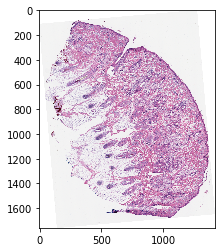

In [81]:
plt.imshow(RandRotate(max_angle=20)(df['image'][0].values[0])[0].numpy()[0].transpose((1,2,0)))

In [38]:
arr=torch.tensor(cv2.resize(cv2.cvtColor(cv2.imread("complete/0_A1b.0.png"),cv2.COLOR_BGR2RGB),None,fx=1/4,fy=1/4)).permute((2,0,1)).unsqueeze(0)/255.#.shape

In [40]:
# arr

tensor([[[[0.9333, 0.9451, 0.9412,  ..., 0.9569, 0.9569, 0.9569],
          [0.9490, 0.9451, 0.9490,  ..., 0.9569, 0.9569, 0.9608],
          [0.9451, 0.9373, 0.9412,  ..., 0.9569, 0.9569, 0.9569],
          ...,
          [0.9529, 0.9529, 0.9569,  ..., 0.9490, 0.9490, 0.9490],
          [0.9569, 0.9569, 0.9569,  ..., 0.9490, 0.9490, 0.9490],
          [0.9569, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9490]],

         [[0.9451, 0.9373, 0.9373,  ..., 0.9569, 0.9608, 0.9608],
          [0.9451, 0.9412, 0.9412,  ..., 0.9569, 0.9569, 0.9608],
          [0.9412, 0.9451, 0.9412,  ..., 0.9569, 0.9569, 0.9569],
          ...,
          [0.9569, 0.9608, 0.9608,  ..., 0.9490, 0.9490, 0.9569],
          [0.9569, 0.9529, 0.9569,  ..., 0.9529, 0.9529, 0.9569],
          [0.9569, 0.9569, 0.9569,  ..., 0.9608, 0.9569, 0.9529]],

         [[0.9451, 0.9412, 0.9490,  ..., 0.9569, 0.9569, 0.9569],
          [0.9412, 0.9490, 0.9569,  ..., 0.9569, 0.9608, 0.9569],
          [0.9451, 0.9490, 0.9490,  ..., 0

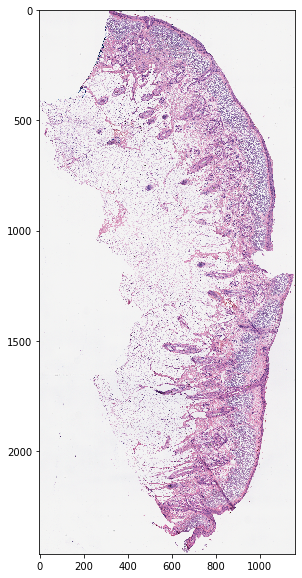

In [34]:
# import matplotlib, matplotlib.pyplot as plt
# plt.figure(figsize=(10,10))
# plt.imshow(arr)